In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
    pass
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.utils import class_weight
from timm.models.swin_transformer import SwinTransformer

# Define the dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, split, transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
        self.file_paths = []
        self.labels = []
        self.load_data()
        self.calculate_class_weights()

    def load_data(self):
        for class_name in self.class_names:
            class_dir = os.path.join(self.data_dir, self.split, class_name)
            if os.path.exists(class_dir):  # Check if directory exists
                for filename in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, filename)
                    self.file_paths.append(file_path)
                    self.labels.append(self.class_names.index(class_name))

    def calculate_class_weights(self):
        # Calculate class weights for balancing the dataset
        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(self.labels), y=self.labels)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32)
        if len(self.class_weights) < len(self.class_names):
            # Pad the class_weights tensor to have the correct size
            self.class_weights = torch.cat([self.class_weights, torch.tensor([1.0], dtype=torch.float32)], dim=0)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')  # Ensure image has 3 channels
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define the data augmentation transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Specify the path to the dataset directory
data_dir = '../input/chest-xray-pneumoniacovid19tuberculosis/'

# Load the data
train_dataset = ChestXRayDataset(data_dir=data_dir, split='train', transform=data_transforms['train'])
val_dataset = ChestXRayDataset(data_dir=data_dir, split='val', transform=data_transforms['val'])
test_dataset = ChestXRayDataset(data_dir=data_dir, split='test', transform=data_transforms['test'])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Define the Swin Transformer model
model = SwinTransformer(
    img_size=224,
    patch_size=4,
    in_chans=3,
    num_classes=len(train_dataset.class_names),
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=7,
    mlp_ratio=4.,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.,
    attn_drop_rate=0.,
    drop_path_rate=0.1,
    norm_layer=nn.LayerNorm,
    ape=False,
    patch_norm=True,
    use_checkpoint=False
)

# Move the model to the GPU
device = torch.device("cuda")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=train_dataset.class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 50

for epoch in range(num_epochs):
    # Training loop
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.2f}%')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/50], Validation Accuracy: 38.46%
Epoch [2/50], Validation Accuracy: 38.46%
Epoch [3/50], Validation Accuracy: 38.46%
Epoch [4/50], Validation Accuracy: 57.69%
Epoch [5/50], Validation Accuracy: 65.38%
Epoch [6/50], Validation Accuracy: 57.69%
Epoch [7/50], Validation Accuracy: 65.38%
Epoch [8/50], Validation Accuracy: 69.23%
Epoch [9/50], Validation Accuracy: 61.54%
Epoch [10/50], Validation Accuracy: 73.08%
Epoch [11/50], Validation Accuracy: 69.23%
Epoch [12/50], Validation Accuracy: 65.38%
Epoch [13/50], Validation Accuracy: 65.38%
Epoch [14/50], Validation Accuracy: 65.38%
Epoch [15/50], Validation Accuracy: 69.23%
Epoch [16/50], Validation Accuracy: 69.23%
Epoch [17/50], Validation Accuracy: 69.23%
Epoch [18/50], Validation Accuracy: 65.38%
Epoch [19/50], Validation Accuracy: 73.08%
Epoch [20/50], Validation Accuracy: 65.38%
Epoch [21/50], Validation Accuracy: 76.92%
Epoch [22/50], Validation Accuracy: 76.92%
Epoch [23/50], Validation Accuracy: 76.92%
Epoch [24/50], Valid

Epoch [1/50], Train Loss: 1.1291, Val Loss: 1.4486, Val Accuracy: 0.3077, Val Precision: 0.1893, Val Recall: 0.3077, Val F1-score: 0.2344
Epoch [2/50], Train Loss: 1.0558, Val Loss: 1.4445, Val Accuracy: 0.3846, Val Precision: 0.3122, Val Recall: 0.3846, Val F1-score: 0.2707
Epoch [3/50], Train Loss: 1.0302, Val Loss: 1.2256, Val Accuracy: 0.3462, Val Precision: 0.2949, Val Recall: 0.3462, Val F1-score: 0.2179
Epoch [4/50], Train Loss: 0.9797, Val Loss: 1.1121, Val Accuracy: 0.5385, Val Precision: 0.8154, Val Recall: 0.5385, Val F1-score: 0.5212
Epoch [5/50], Train Loss: 0.9651, Val Loss: 1.2033, Val Accuracy: 0.5000, Val Precision: 0.8095, Val Recall: 0.5000, Val F1-score: 0.4658
Epoch [6/50], Train Loss: 0.9325, Val Loss: 1.0287, Val Accuracy: 0.5385, Val Precision: 0.8154, Val Recall: 0.5385, Val F1-score: 0.5187
Epoch [7/50], Train Loss: 0.8992, Val Loss: 0.6781, Val Accuracy: 0.6538, Val Precision: 0.7531, Val Recall: 0.6538, Val F1-score: 0.6212
Epoch [8/50], Train Loss: 0.8388, 

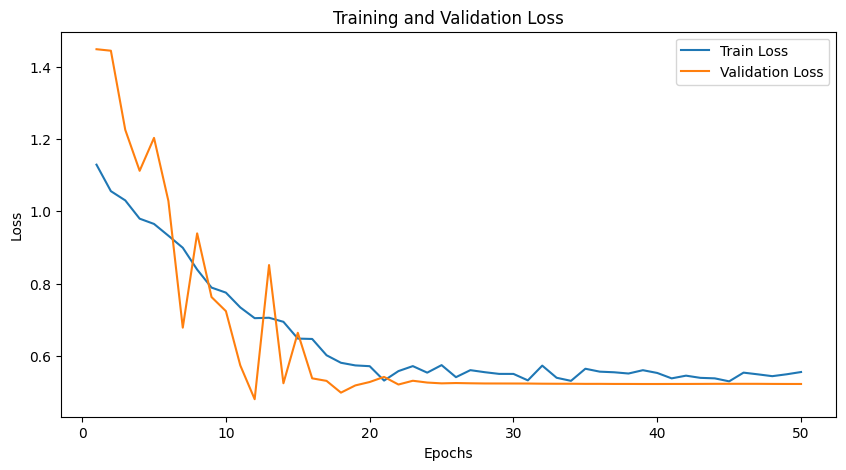

Test Accuracy: 0.7603, Test Precision: 0.7850, Test Recall: 0.7603, Test F1-score: 0.7640
Confusion Matrix:
[[ 98   3   5]
 [ 38 168  28]
 [ 22  79 289]]


In [17]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.utils import class_weight
from timm.models.swin_transformer import SwinTransformer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, split, transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
        self.file_paths = []
        self.labels = []
        self.load_data()
        self.calculate_class_weights()

    def load_data(self):
        for class_name in self.class_names:
            class_dir = os.path.join(self.data_dir, self.split, class_name)
            if os.path.exists(class_dir):  
                for filename in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, filename)
                    self.file_paths.append(file_path)
                    self.labels.append(self.class_names.index(class_name))

    def calculate_class_weights(self):
        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(self.labels), y=self.labels)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32)
        if len(self.class_weights) < len(self.class_names):
            self.class_weights = torch.cat([self.class_weights, torch.tensor([1.0], dtype=torch.float32)], dim=0)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define the data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = val_transform

# Specify the path to the dataset directory
data_dir = '../input/chest-xray-pneumoniacovid19tuberculosis/'

# Load the data
train_dataset = ChestXRayDataset(data_dir=data_dir, split='train', transform=train_transform)
val_dataset = ChestXRayDataset(data_dir=data_dir, split='val', transform=val_transform)
test_dataset = ChestXRayDataset(data_dir=data_dir, split='test', transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Define the Swin Transformer model
model = SwinTransformer(
    img_size=224,
    patch_size=4,
    in_chans=3,
    num_classes=len(train_dataset.class_names),
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=7,
    mlp_ratio=4.,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.1,  
    attn_drop_rate=0.1,
    drop_path_rate=0.1,
    norm_layer=nn.LayerNorm,
    ape=False,
    patch_norm=True,
    use_checkpoint=False
)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=train_dataset.class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

# Train the model
num_epochs = 50

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_predictions.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Calculate validation metrics
    val_accuracy = accuracy_score(val_targets, val_predictions)
    val_precision = precision_score(val_targets, val_predictions, average='weighted', zero_division=0)
    val_recall = recall_score(val_targets, val_predictions, average='weighted', zero_division=0)
    val_f1 = f1_score(val_targets, val_predictions, average='weighted', zero_division=0)
    confusion = confusion_matrix(val_targets, val_predictions)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}, '
          f'Val Precision: {val_precision:.4f}, '
          f'Val Recall: {val_recall:.4f}, '
          f'Val F1-score: {val_f1:.4f}')

    # Learning rate scheduler step
    scheduler.step(epoch_val_loss)

# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
model.eval()
test_predictions = []
test_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_predictions.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_predictions)
test_precision = precision_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_recall = recall_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_f1 = f1_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_confusion = confusion_matrix(test_targets, test_predictions)

print(f'Test Accuracy: {test_accuracy:.4f}, '
      f'Test Precision: {test_precision:.4f}, '
      f'Test Recall: {test_recall:.4f}, '
      f'Test F1-score: {test_f1:.4f}')
print('Confusion Matrix:')
print(test_confusion)


In [18]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, split, transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
        self.file_paths = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for class_name in self.class_names:
            class_dir = os.path.join(self.data_dir, self.split, class_name)
            if os.path.exists(class_dir):  
                for filename in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, filename)
                    self.file_paths.append(file_path)
                    self.labels.append(self.class_names.index(class_name))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the data
data_dir = '../input/chest-xray-pneumoniacovid19tuberculosis/'
train_dataset = ChestXRayDataset(data_dir=data_dir, split='train', transform=train_transform)
val_dataset = ChestXRayDataset(data_dir=data_dir, split='val', transform=val_transform)
test_dataset = ChestXRayDataset(data_dir=data_dir, split='test', transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Define the ResNet-50 model
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.class_names))

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.1)

# Training loop
num_epochs = 50
best_val_accuracy = 0.0
patience = 5
counter = 0
best_model_weights = None

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    epoch_train_loss = train_loss / len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_predictions.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    val_accuracy = accuracy_score(val_targets, val_predictions)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

    # Update learning rate scheduler
    scheduler.step(val_accuracy)

    # Early stopping and model checkpointing
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        counter = 0
        best_model_weights = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

# Load the best model weights
if best_model_weights:
    model.load_state_dict(best_model_weights)

# Evaluate the model on the test set
model.eval()
test_predictions = []
test_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_predictions.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_predictions)
test_precision = precision_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_recall = recall_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_f1 = f1_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_confusion = confusion_matrix(test_targets, test_predictions)

print(f'Test Accuracy: {test_accuracy:.4f}, '
      f'Test Precision: {test_precision:.4f}, '
      f'Test Recall: {test_recall:.4f}, '
      f'Test F1-score: {test_f1:.4f}')
print('Confusion Matrix:')
print(test_confusion)


Epoch [1/50], Train Loss: 0.3608, Val Accuracy: 0.9615
Epoch [2/50], Train Loss: 0.2572, Val Accuracy: 0.8462
Epoch [3/50], Train Loss: 0.2149, Val Accuracy: 0.8846
Epoch [4/50], Train Loss: 0.2040, Val Accuracy: 0.9615
Epoch [5/50], Train Loss: 0.2102, Val Accuracy: 0.7692
Epoch [6/50], Train Loss: 0.1656, Val Accuracy: 0.9615
Early stopping
Test Accuracy: 0.9616, Test Precision: 0.9625, Test Recall: 0.9616, Test F1-score: 0.9613
Confusion Matrix:
[[106   0   0]
 [  0 211  23]
 [  0   5 385]]


Epoch [1/50], Train Loss: 0.3814, Val Loss: 0.3419, Val Accuracy: 0.8077
Epoch [2/50], Train Loss: 0.2257, Val Loss: 0.3336, Val Accuracy: 0.8462
Epoch [3/50], Train Loss: 0.2076, Val Loss: 0.4282, Val Accuracy: 0.7692
Epoch [4/50], Train Loss: 0.1950, Val Loss: 0.1036, Val Accuracy: 0.9615
Epoch [5/50], Train Loss: 0.1817, Val Loss: 0.5153, Val Accuracy: 0.7692
Epoch [6/50], Train Loss: 0.1665, Val Loss: 0.4436, Val Accuracy: 0.7692
Epoch [7/50], Train Loss: 0.1623, Val Loss: 0.4470, Val Accuracy: 0.7692
Epoch [8/50], Train Loss: 0.1587, Val Loss: 0.1923, Val Accuracy: 0.9231
Epoch [9/50], Train Loss: 0.1477, Val Loss: 0.5045, Val Accuracy: 0.7692
Epoch [10/50], Train Loss: 0.1503, Val Loss: 0.3910, Val Accuracy: 0.7692
Epoch [11/50], Train Loss: 0.1507, Val Loss: 0.2247, Val Accuracy: 0.9231
Epoch [12/50], Train Loss: 0.1528, Val Loss: 0.4015, Val Accuracy: 0.8077
Epoch [13/50], Train Loss: 0.1424, Val Loss: 0.6268, Val Accuracy: 0.7692
Epoch [14/50], Train Loss: 0.1289, Val Loss: 0.

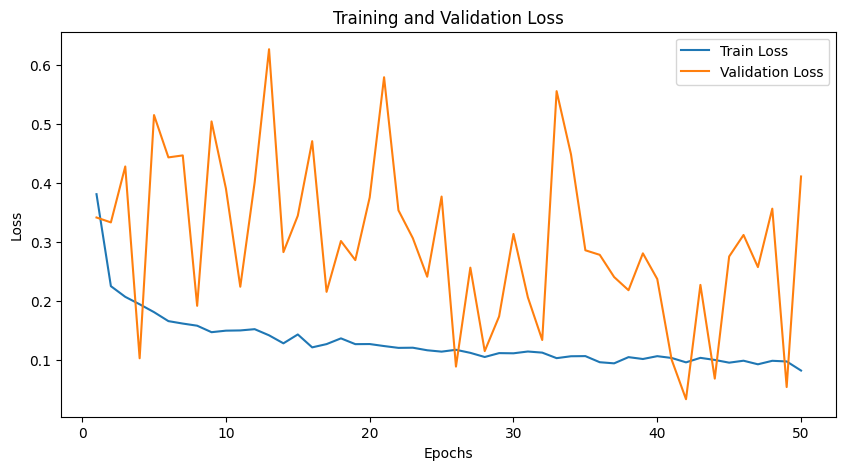

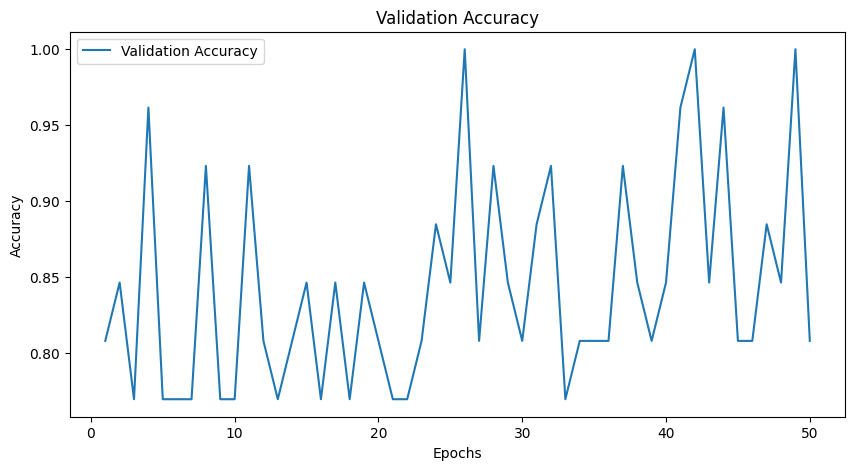

Test Accuracy: 0.9397, Test Precision: 0.9446, Test Recall: 0.9397, Test F1-score: 0.9384
Confusion Matrix:
[[105   1   0]
 [  0 192  42]
 [  0   1 389]]


In [19]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet121
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, split, transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
        self.file_paths = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for class_name in self.class_names:
            class_dir = os.path.join(self.data_dir, self.split, class_name)
            if os.path.exists(class_dir):  
                for filename in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, filename)
                    self.file_paths.append(file_path)
                    self.labels.append(self.class_names.index(class_name))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the data
data_dir = '../input/chest-xray-pneumoniacovid19tuberculosis/'
train_dataset = ChestXRayDataset(data_dir=data_dir, split='train', transform=train_transform)
val_dataset = ChestXRayDataset(data_dir=data_dir, split='val', transform=val_transform)
test_dataset = ChestXRayDataset(data_dir=data_dir, split='test', transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Define the DenseNet-121 model
model = densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(train_dataset.class_names))

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.1)

# Training loop with plotting
num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    epoch_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_predictions.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # Calculate validation metrics
    val_accuracy = accuracy_score(val_targets, val_predictions)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
model.eval()
test_predictions = []
test_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_predictions.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_predictions)
test_precision = precision_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_recall = recall_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_f1 = f1_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_confusion = confusion_matrix(test_targets, test_predictions)

print(f'Test Accuracy: {test_accuracy:.4f}, '
      f'Test Precision: {test_precision:.4f}, '
      f'Test Recall: {test_recall:.4f}, '
      f'Test F1-score: {test_f1:.4f}')
print('Confusion Matrix:')
print(test_confusion)


**Result of Densent121**
Test Accuracy: 0.9562, Test Precision: 0.9586, Test Recall: 0.9562, Test F1-score: 0.9555
Confusion Matrix:
[[105   1   0]
 [  0 204  30]
 [  0   1 389]]

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 147MB/s]  


Epoch [1/50], Train Loss: 0.3483, Val Loss: 0.5437, Val Accuracy: 0.7692
Epoch [2/50], Train Loss: 0.2205, Val Loss: 0.4685, Val Accuracy: 0.8462
Epoch [3/50], Train Loss: 0.1938, Val Loss: 0.2992, Val Accuracy: 0.8462
Epoch [4/50], Train Loss: 0.1782, Val Loss: 0.4348, Val Accuracy: 0.7692
Epoch [5/50], Train Loss: 0.1749, Val Loss: 0.2659, Val Accuracy: 0.8462
Epoch [6/50], Train Loss: 0.1658, Val Loss: 0.4351, Val Accuracy: 0.7692
Epoch [7/50], Train Loss: 0.1607, Val Loss: 0.4241, Val Accuracy: 0.8462
Epoch [8/50], Train Loss: 0.1478, Val Loss: 0.2259, Val Accuracy: 0.8462
Epoch [9/50], Train Loss: 0.1510, Val Loss: 0.5140, Val Accuracy: 0.7692
Epoch [10/50], Train Loss: 0.1348, Val Loss: 0.2468, Val Accuracy: 0.8846
Epoch [11/50], Train Loss: 0.1462, Val Loss: 0.3829, Val Accuracy: 0.8077
Epoch [12/50], Train Loss: 0.1312, Val Loss: 0.1049, Val Accuracy: 0.9615
Epoch [13/50], Train Loss: 0.1314, Val Loss: 0.1114, Val Accuracy: 0.9231
Epoch [14/50], Train Loss: 0.1316, Val Loss: 0.

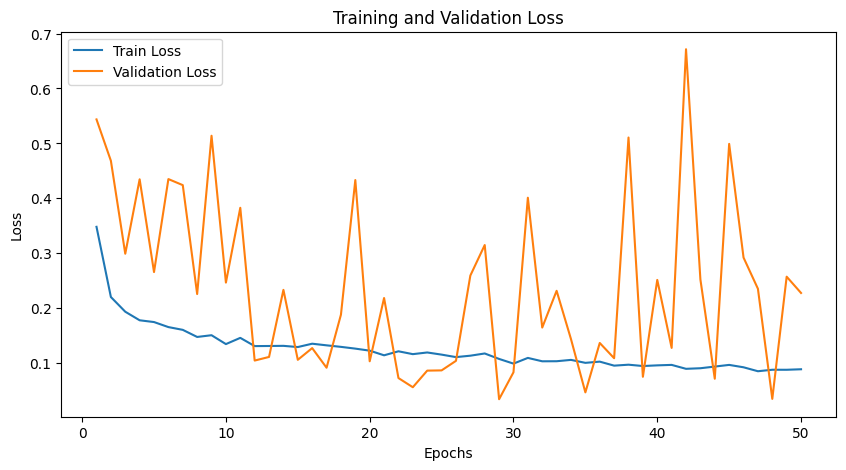

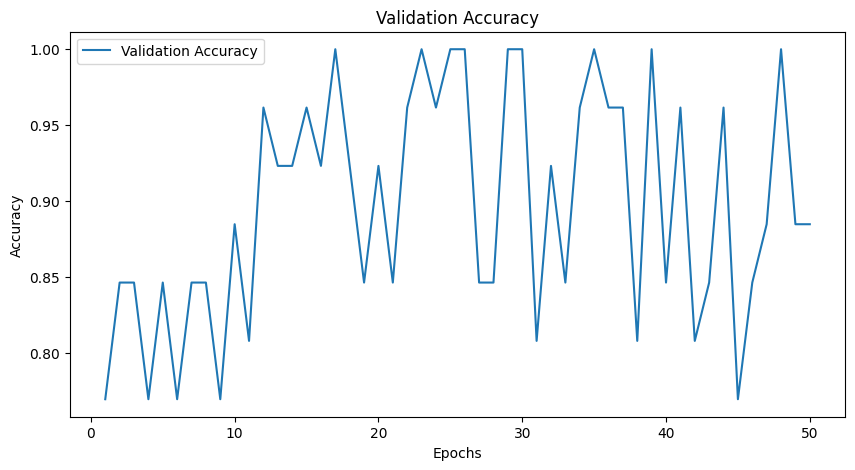

Test Accuracy: 0.9288, Test Precision: 0.9357, Test Recall: 0.9288, Test F1-score: 0.9271
Confusion Matrix:
[[103   1   2]
 [  0 186  48]
 [  0   1 389]]


In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet161  # Changed the model here
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, split, transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
        self.file_paths = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for class_name in self.class_names:
            class_dir = os.path.join(self.data_dir, self.split, class_name)
            if os.path.exists(class_dir):  
                for filename in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, filename)
                    self.file_paths.append(file_path)
                    self.labels.append(self.class_names.index(class_name))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the data
data_dir = '../input/chest-xray-pneumoniacovid19tuberculosis/'
train_dataset = ChestXRayDataset(data_dir=data_dir, split='train', transform=train_transform)
val_dataset = ChestXRayDataset(data_dir=data_dir, split='val', transform=val_transform)
test_dataset = ChestXRayDataset(data_dir=data_dir, split='test', transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Define the DenseNet-161 model
model = densenet161(pretrained=True)  # Changed the model here
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(train_dataset.class_names))

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.1)

# Training loop with plotting
num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    epoch_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_predictions.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # Calculate validation metrics
    val_accuracy = accuracy_score(val_targets, val_predictions)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
model.eval()
test_predictions = []
test_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_predictions.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_predictions)
test_precision = precision_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_recall = recall_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_f1 = f1_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_confusion = confusion_matrix(test_targets, test_predictions, labels=np.arange(len(train_dataset.class_names)))  # Ensure the confusion matrix considers all classes

print(f'Test Accuracy: {test_accuracy:.4f}, '
      f'Test Precision: {test_precision:.4f}, '
      f'Test Recall: {test_recall:.4f}, '
      f'Test F1-score: {test_f1:.4f}')
print('Confusion Matrix:')
print(test_confusion)


Epoch [1/50], Train Loss: 0.7003, Val Loss: 0.9258, Val Accuracy: 0.4615
Epoch [2/50], Train Loss: 0.5021, Val Loss: 0.6058, Val Accuracy: 0.6923
Epoch [3/50], Train Loss: 0.4212, Val Loss: 0.6195, Val Accuracy: 0.6923
Epoch [4/50], Train Loss: 0.3802, Val Loss: 0.6288, Val Accuracy: 0.6923
Epoch [5/50], Train Loss: 0.3732, Val Loss: 0.4028, Val Accuracy: 0.8077
Epoch [6/50], Train Loss: 0.3530, Val Loss: 0.5034, Val Accuracy: 0.7308
Epoch [7/50], Train Loss: 0.3378, Val Loss: 0.4386, Val Accuracy: 0.7308
Epoch [8/50], Train Loss: 0.3287, Val Loss: 0.3967, Val Accuracy: 0.8077
Epoch [9/50], Train Loss: 0.3203, Val Loss: 0.4891, Val Accuracy: 0.7308
Epoch [10/50], Train Loss: 0.3203, Val Loss: 0.3740, Val Accuracy: 0.8077
Epoch [11/50], Train Loss: 0.3093, Val Loss: 0.5493, Val Accuracy: 0.7692
Epoch [12/50], Train Loss: 0.3089, Val Loss: 0.4728, Val Accuracy: 0.7308
Epoch [13/50], Train Loss: 0.2992, Val Loss: 0.4680, Val Accuracy: 0.7692
Epoch [14/50], Train Loss: 0.3071, Val Loss: 0.

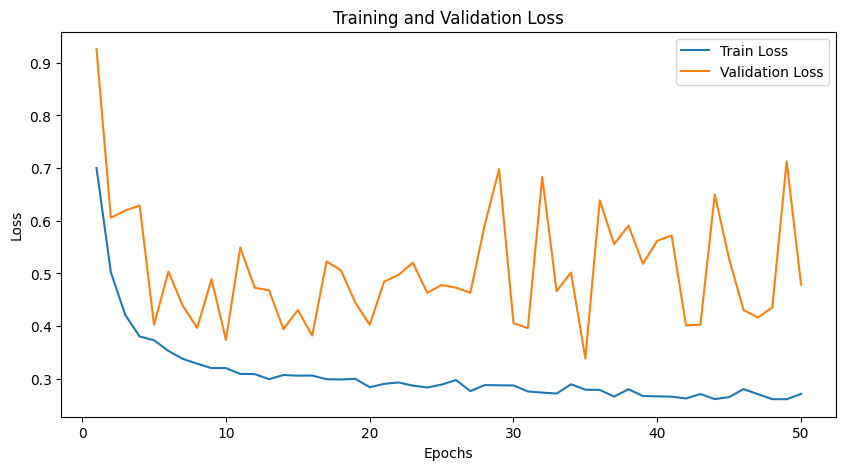

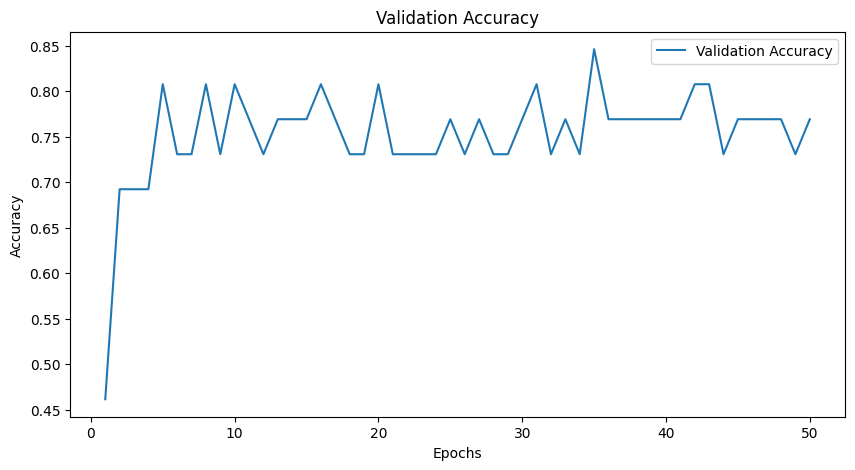

NameError: name 'test_tarets' is not defined

In [20]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet161
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, split, transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
        self.file_paths = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for class_name in self.class_names:
            class_dir = os.path.join(self.data_dir, self.split, class_name)
            if os.path.exists(class_dir):  
                for filename in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, filename)
                    self.file_paths.append(file_path)
                    self.labels.append(self.class_names.index(class_name))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the data
data_dir = '../input/chest-xray-pneumoniacovid19tuberculosis/'
train_dataset = ChestXRayDataset(data_dir=data_dir, split='train', transform=train_transform)
val_dataset = ChestXRayDataset(data_dir=data_dir, split='val', transform=val_transform)
test_dataset = ChestXRayDataset(data_dir=data_dir, split='test', transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Define the DenseNet-161 model
model = densenet161(pretrained=True)
num_ftrs = model.classifier.in_features

# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

# Define new fully connected layer
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # Adjust the number of output features as needed
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, len(train_dataset.class_names))  # Adjust the number of classes
)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.1)

# Training loop with plotting
num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    epoch_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_predictions.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # Calculate validation metrics
    val_accuracy = accuracy_score(val_targets, val_predictions)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
model.eval()
test_predictions = []
test_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_predictions.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_predictions)
test_precision = precision_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_recall = recall_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_f1 = f1_score(test_tarets, test_predictions, average='weighted', zero_division=0)
test_confusion = confusion_matrix(test_targets, test_predictions, labels=np.arange(len(train_dataset.class_names)))

print(f'Test Accuracy: {test_accuracy:.4f}, '
      f'Test Precision: {test_precision:.4f}, '
      f'Test Recall: {test_recall:.4f}, '
      f'Test F1-score: {test_f1:.4f}')
print('Confusion Matrix:')
print(test_confusion)


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Define the dataset class for text data
class ChestXRayTextDataset(Dataset):
    def __init__(self, data_dir, split, tokenizer, max_length):
        self.data_dir = data_dir
        self.split = split
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
        self.file_paths = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for class_name in self.class_names:
            class_dir = os.path.join(self.data_dir, self.split, class_name)
            if os.path.exists(class_dir):  
                for filename in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, filename)
                    self.file_paths.append(file_path)
                    self.labels.append(self.class_names.index(class_name))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        with open(self.file_paths[idx], 'r', encoding='utf-8') as file:
            text = file.read()
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        return input_ids, attention_mask, label

# Define data augmentation transforms for images
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the dataset class for image data
class ChestXRayImageDataset(Dataset):
    def __init__(self, data_dir, split, transform):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
        self.file_paths = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for class_name in self.class_names:
            class_dir = os.path.join(self.data_dir, self.split, class_name)
            if os.path.exists(class_dir):  
                for filename in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, filename)
                    self.file_paths.append(file_path)
                    self.labels.append(self.class_names.index(class_name))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define the combined dataset class
class ChestXRayCombinedDataset(Dataset):
    def __init__(self, text_dataset, image_dataset):
        self.text_dataset = text_dataset
        self.image_dataset = image_dataset

    def __len__(self):
        return min(len(self.text_dataset), len(self.image_dataset))

    def __getitem__(self, idx):
        text_data = self.text_dataset[idx]
        image_data = self.image_dataset[idx]
        return (text_data[0], text_data[1], image_data[0]), text_data[2]

# Load the data for text and image separately
data_dir_text = '../input/chest-xray-pneumoniacovid19tuberculosis/'
max_length = 512  # Maximum sequence length for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_text_dataset = ChestXRayTextDataset(data_dir=data_dir_text, split='train', tokenizer=tokenizer, max_length=max_length)
val_text_dataset = ChestXRayTextDataset(data_dir=data_dir_text, split='val', tokenizer=tokenizer, max_length=max_length)
test_text_dataset = ChestXRayTextDataset(data_dir=data_dir_text, split='test', tokenizer=tokenizer, max_length=max_length)

data_dir_image = '../input/chest-xray-pneumoniacovid19tuberculosis/'  # Change this path if image data is stored elsewhere
train_image_dataset = ChestXRayImageDataset(data_dir=data_dir_image, split='train', transform=train_transform)
val_image_dataset = ChestXRayImageDataset(data_dir=data_dir_image, split='val', transform=val_transform)
test_image_dataset = ChestXRayImageDataset(data_dir=data_dir_image, split='test', transform=val_transform)

# Create combined datasets
train_dataset = ChestXRayCombinedDataset(train_text_dataset, train_image_dataset)
val_dataset = ChestXRayCombinedDataset(val_text_dataset, val_image_dataset)
test_dataset = ChestXRayCombinedDataset(test_text_dataset, test_image_dataset)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop with plotting
num_epochs = 3  # You may increase this depending on resources
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Ensure the input tensor has the correct shape and type
        if len(inputs[0].size()) != 2:
            raise ValueError(f"Input tensor has incorrect shape: {inputs[0].size()}. Expected: (batch_size, sequence_length)")
        if inputs[0].dtype != torch.long:
            raise ValueError(f"Input tensor has incorrect type: {inputs[0].dtype}. Expected: torch.long")
        
        optimizer.zero_grad()
        outputs = model(inputs[0], attention_mask=inputs[1])
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs[0].size(0)
    epoch_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs[0], attention_mask=inputs[1])
            _, preds = torch.max(outputs.logits, 1)
            val_predictions.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
            val_loss += criterion(outputs.logits, labels).item() * inputs[0].size(0)
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # Calculate validation metrics
    val_accuracy = accuracy_score(val_targets, val_predictions)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
model.eval()
test_predictions = []
test_targets = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs[0], attention_mask=inputs[1])
        _, preds = torch.max(outputs.logits, 1)
        test_predictions.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_predictions)
test_precision = precision_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_recall = recall_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_f1 = f1_score(test_targets, test_predictions, average='weighted', zero_division=0)
test_confusion = confusion_matrix(test_targets, test_predictions)

print(f'Test Accuracy: {test_accuracy:.4f}, '
      f'Test Precision: {test_precision:.4f}, '
      f'Test Recall: {test_recall:.4f}, '
      f'Test F1-score: {test_f1:.4f}')
print('Confusion Matrix:')
print(test_confusion)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
